# Astronomy words

I web-scraped the articles on the web-portal https://www.popularastronomi.se/ and counted the frequency of astronomy related words. Note that the articles are in Swedish.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # Maybe not necessary.

from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions for web-scraping and text manipulation

In [12]:
def get_links_year(year):
    '''
    Scrapes 'www.popularastronomi.se/' for news in the given year.
    '''
    links = []
    page = 1

    while True:
        link = f'https://www.popularastronomi.se/{year}/page/{page}/'

        response = requests.get(link)
        if response.status_code == 404:
            break

        soup = BeautifulSoup(response.content)

        for link in soup.find_all('a'):
            if link.has_attr('rel'):
                if link['rel'] == ['bookmark']:
                    links.append(link['href'])
        page += 1
    
    links = list(set(links))
    return links

def get_links(years, save=False, filename_suffix=''):
    '''
    Scrapes 'www.popularastronomi.se/' for news in the given list of years.
    '''
    links = list(set([link for year in years for link in get_links_year(year)]))
    links.sort()
    
    if save:
        filename = f'output//links{filename_suffix}.txt' 
        with open(filename, 'w') as file:
            for link in links:
                file.write("%s\n" % link)
                
    return links

def get_one_text(link):
    '''
    Scrapes an article on 'www.popularastronomi.se/' for text.
    '''
    response = requests.get(link)
    soup = BeautifulSoup(response.content)

    text = soup.title.text[: -len(' - Populär Astronomi')] + '\n' # Remove ' - Populär Astronomi' which appears in every title.
    for parag in soup.find_all('p')[:-2]: # The last two 'p's are some bookmarks or similar.
        text += parag.text.replace('\xa0', ' ') + '\n'

    return text

def get_texts(links, save=False, filename_suffix=''):
    '''
    Returns one string with all texts on the given list of links.
    '''
    all_text = ''
    for link in links:
        all_text += get_one_text(link)    

    if save:
        filename = f'output//text{filename_suffix}.txt'
        with open(filename, 'w', encoding="utf-8") as file:
            file.write(all_text)
                
    return all_text
    
def get_words_freq(text, save=False, filename_suffix=''):
    '''
    Returns the list of all words with their frequencies
    from the text, excluding stopwords.
    '''
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    words = [word.lower() for word in tokenizer.tokenize(text)]
    
    language = 'swedish'
    stop_words = stopwords.words(language)
    
    # Add to file 'more_stop_words.txt' manually more non-astronomy words.
    try:
        with open('more_stop_words.txt', 'r', encoding="utf-8") as file:
            content = file.read()
        more_stop_words = eval(content)
    except:
        more_stop_words = []
    
    stop_words += more_stop_words
    words = [word for word in words if word not in stop_words]
    
    words_freq = nltk.FreqDist(words).most_common()
    
    if save:
        filename = f'output//words_freq{filename_suffix}.txt'
        with open(filename, 'w', encoding='utf-8') as file:
            for word, count in words_freq:
                file.write(f'{word} : {count}\n')
            
    return words_freq
            
def scrape_words(years, save=False, filename_suffix=''):
    '''
    Composes the previos functions,
    i.e. gives the list of words with their frequencies, 
    from all the text in the given list of years.
    '''
    links = get_links(years, save=save, filename_suffix=filename_suffix)
    text = get_texts(links, save=save, filename_suffix=filename_suffix)
    words_freq = get_words_freq(text, save=save, filename_suffix=filename_suffix)
    
    return words_freq

def generate_word_cloud(words_freq, save=False, filename_suffix=''):
    '''
    Generates word cloud out of the frequencies.
    '''
    wordcloud = WordCloud(background_color="white", width=1200, height=600)
    wordcloud.generate_from_frequencies(frequencies=dict(words_freq))
    
    if save:
        filename = f'output//word_cloud{filename_suffix}.png'
        wordcloud.to_file(filename)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# Reading from previously saved files,
# so that we do not need to re-scrape.

def read_text(filename_suffix=''):
    '''
    Tries to read previously saved text.
    '''
    filename = f'output//text{filename_suffix}.txt'
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()  
            
    return text

def read_words_freq(filename_suffix=''):
    '''
    Tries to read previously saved word frequencies.
    '''
    words_freq = []
    filename = f'output//words_freq{filename_suffix}.txt'
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()  
        
    for line in lines:
        word, count = line.split(' : ')
        count = int(count)
        words_freq.append((word, count))
            
    return words_freq

### Let's try it for each of the last several years

Most frequent astronomy words in 2021:
stjärnor (56), stjärna (52), jorden (48), rymden (48), solen (44), mars (42), esa (36), planeter (36), astronomi (32), månen (31)


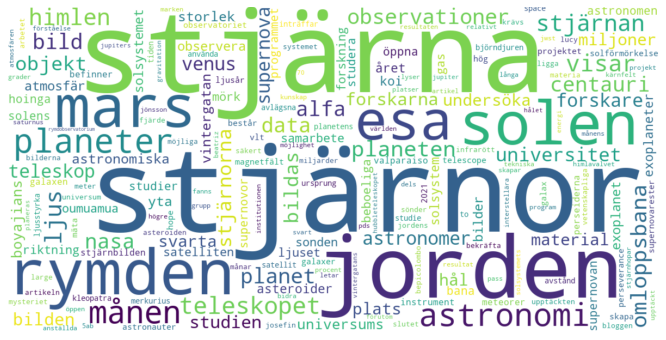

Most frequent astronomy words in 2020:
mars (165), jorden (103), venus (80), nasa (77), stjärnor (77), månen (70), solen (66), planeten (64), astronomi (63), himlen (60)


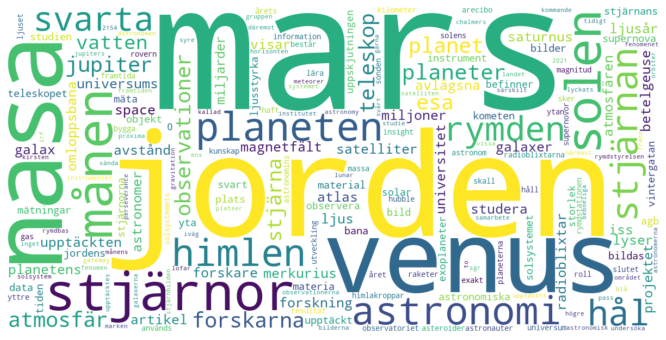

Most frequent astronomy words in 2019:
månen (123), jorden (97), solen (83), mars (82), jupiter (64), saturnus (64), rymden (61), stjärnor (59), nasa (57), svarta (57)


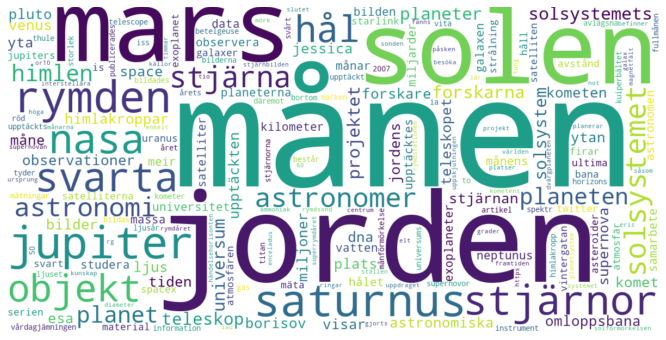

In [3]:
for year in [2021, 2020, 2019]:
    suffix = f'_{year}'
    words_freq = scrape_words([year], save=True, filename_suffix=suffix)
    
    print(f'Most frequent astronomy words in {year}:')
    print(', '.join(f'{word} ({freq})' for word, freq in words_freq[:10]))
    
    generate_word_cloud(words_freq, save=True, filename_suffix=suffix)
    
# Check out files in 'output.txt'.

### What about the last decade

Most frequent astronomy words in 2011-2021:
mars (882), jorden (842), nasa (811), stjärnor (701), rymden (673), solen (635), månen (595), himlen (589), astronomi (581), planeter (487)


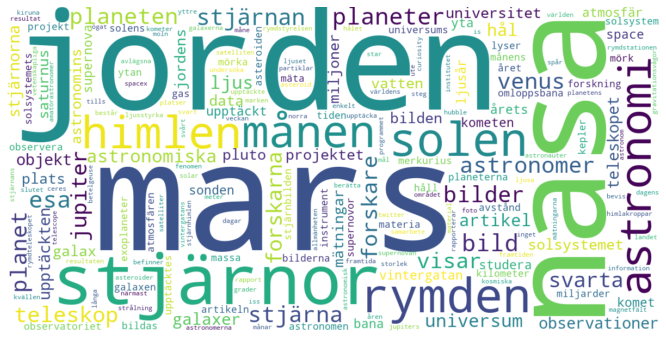

In [4]:
# Warning: Takes about six minutes on my laptop.
# You can change the period from 2004 uppwards.

begin_period = 2011
end_period = 2021

years = list(range(begin_period, end_period + 1))
suffix = f'_{begin_period}-{end_period}'
words_freq = scrape_words(years, save=True, filename_suffix=suffix)

print(f'Most frequent astronomy words in {begin_period}-{end_period}:')
print(', '.join(f'{word} ({freq})' for word, freq in words_freq[:10]))

generate_word_cloud(words_freq, save=True, filename_suffix=suffix)
    
# Check out files in 'output.txt'.

### How do the frequencies of the most frequent words in the past decade change yearly?

In [160]:
top_words = ['månen', 'solen', 'jorden', 'mars',  'nasa', 'rymden', 'stjärnor', ]
years = list(range(2011, 2022))

words_freq_dict = {word : [] for word in top_words}

for year in years:
    suffix = f'_{year}'
    
    # Don't redo the scraping.
    if f'words_freq{suffix}.txt' in os.listdir('output'):
        words_freq = read_words_freq(filename_suffix=suffix)
    else:
        words_freq = scrape_words([year], save=True, filename_suffix=suffix)
    
    words_freq = dict(words_freq) # More convenient to have a dictionary.
    
    total = sum(words_freq.values())
    for word in top_words:
        freq = words_freq[word]
        words_freq_dict[word].append(freq/total * 1000) # Per mille.
        
words_freq_df = pd.DataFrame(words_freq_dict, index=years)
words_freq_df

,månen,solen,jorden,mars,nasa,rymden,stjärnor
2011,1.290495,2.091492,3.381986,1.824493,5.695977,4.093984,4.049484
2012,1.652978,3.667545,3.099334,2.944367,6.147012,4.855623,3.770856
2013,1.945640,4.127115,4.009198,2.594187,4.598785,5.954838,3.124816
2014,0.683485,3.417423,4.038772,3.790232,5.530011,4.908662,2.733938
2015,1.283697,3.246998,4.002114,6.493997,4.681719,3.926603,3.095975
2016,2.806976,2.269470,5.434783,3.822265,3.344482,2.209747,2.747253
2017,5.218435,2.493766,4.802808,2.355223,2.678489,3.232659,3.463563
2018,4.189024,3.953685,6.448273,9.366469,3.906618,2.353384,4.047821
2019,6.384967,4.308555,5.035299,4.256645,2.958887,3.166528,3.062708
2020,3.561072,3.357583,5.239864,8.393956,3.917180,2.492751,3.917180


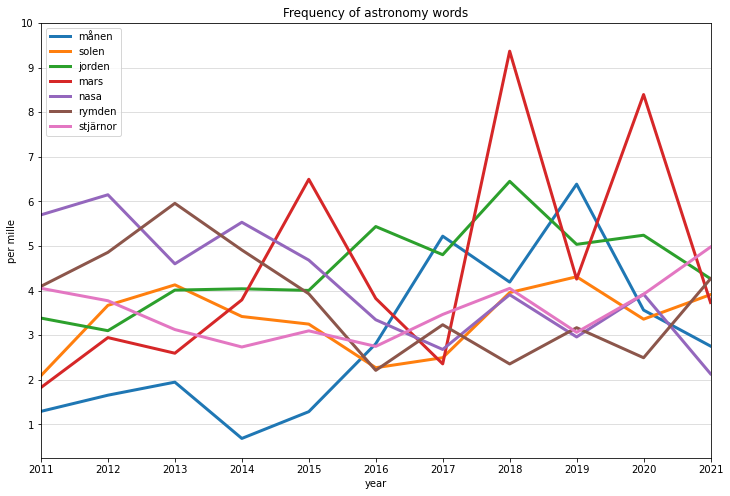

In [163]:
fig, ax = plt.subplots()

ax = words_freq_df.plot(
    kind='line',
    ax = ax,
    figsize=(12, 8),
    linewidth=3.0,
)

ax.set(
    xticks = years,
    xlim=(min(years), max(years)),
    yticks = range(1, round(words_freq_df.max().max()) + 2),
    title='Frequency of astronomy words',
    xlabel='year',
    ylabel='per mille',
)

ax.grid(linestyle='-', axis='y', alpha=0.5)

plt.show()

The peaks of 'mars' in 2018 and 2020 are probably related to Perseverance (see https://en.wikipedia.org/wiki/Mars_2020).